#### Import Required Libraries

In [1]:
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd
 import seaborn as sns
 import tensorflow as tf
 from tensorflow import keras
 from tensorflow.keras import layers, models
 from tensorflow.keras.datasets import mnist
 from sklearn.metrics import mean_squared_error
 from sklearn.decomposition import PCA
 from sklearn.preprocessing import StandardScaler, MinMaxScaler
 from sklearn.ensemble import IsolationForest

# Part 1: CNN Autoencoder

 #### 1. Build a CNN autoencoder to process image data (e.g., the MNIST or CIFAR-10 dataset)

In [2]:
 data = mnist.load_data()
 (x_train, _), (x_test, y_test) = data
 # Normalizing
 x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
 x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0
 print(x_train.shape)
 print(x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


Use convolutional layers in the encoder to extract spatial features.

In [3]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
encoder_outputs = layers.MaxPooling2D(2, padding="same")(x)
encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 8)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

Use transposed convolutional layers in the decoder to reconstruct the images

In [4]:
decoder_inputs = keras.Input(shape=(4, 4, 8))
x = layers.Conv2D(8, 3, activation="relu", padding="same")(decoder_inputs)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,481 (9.69 KB)

 Trainable params: 2,481 (9.69 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, validation_data= (x_test, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3483 - val_loss: 0.1659
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1581 - val_loss: 0.1402
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1391 - val_loss: 0.1308
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1301 - val_loss: 0.1248
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1247 - val_loss: 0.1214
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1215 - val_loss: 0.1186
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1182 - val_loss: 0.1161
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1161 - val_loss: 0.1141
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1144 - val_loss: 0.1123
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1128 - val_loss: 0.1109


Visualize the input and reconstructed images.

In [6]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


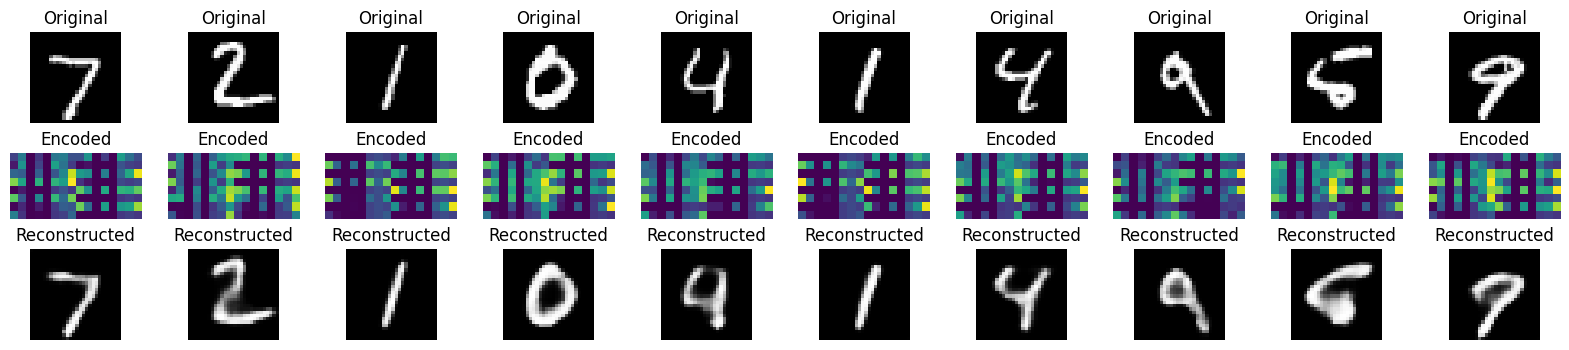

In [7]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original image
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
  ax.set_title("Original")
  ax.axis('off')

  # Display encoded image (use a heatmap or similar visualization)
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(encoded_imgs[i].reshape(8, 16))
  ax.set_title("Encoded")
  ax.axis('off')

  # Display reconstructed image
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
  ax.set_title("Reconstructed")
  ax.axis('off')

plt.show()

 ### 2. Evaluate the autoencoder's ability to compress data:

Measure the Mean Squared Error (MSE) between the original and reconstructed images.

In [8]:
mse = mean_squared_error(x_test.flatten(), decoded_imgs.flatten())
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0165


Visualize the reduced feature space (latent space) using a 2D visualization tool such as t-SNE or PCA.

In [9]:
print(encoded_imgs.shape)

(10000, 4, 4, 8)


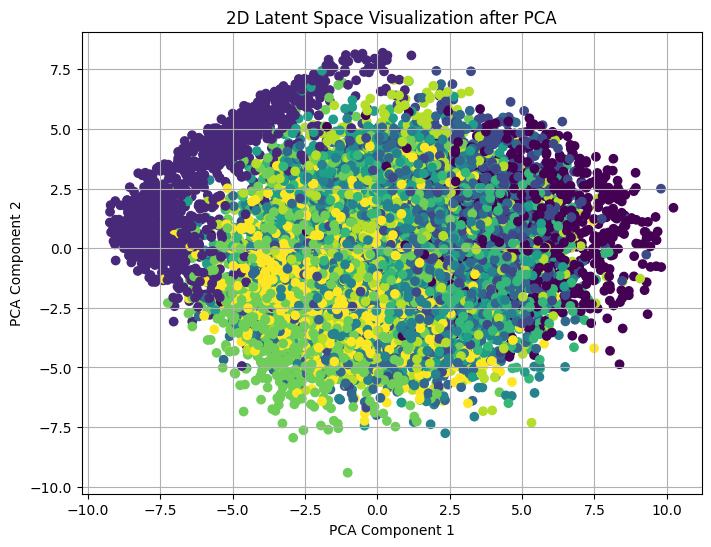

In [10]:
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(encoded_imgs.reshape((-1, 4*4*8)))
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c=y_test, marker='o')
plt.title('2D Latent Space Visualization after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

Key Questions:
 1. How does the CNN autoencoder perform in reconstructing images?
 A low MSE indicates that the model is effectively learning the features necessary to
 reconstruct images with minimal error. A low MSE suggests that the reconstructed images
are quite close to the original ones, with only minor discrepancies that the model couldn't fully
 capture.
 2. What insights do you gain from visualizing the latent space?
 Using PCA to visualize the latent space is a great choice for me as it revealed key structural
 relationships within the compressed features. By reducing the dimensionality of the latent
 space, PCA helped highlight patterns, such as clusters or separable regions, that are
 otherwise difficult to see

# Part 2: LSTM Autoencoder

### 1. Build an LSTM autoencoder to process sequential data (e.g., a dataset of time series data or text sequences):

In [11]:
data2 = pd.read_csv("HistoricalQuotes.csv")
data2.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [12]:
data2['Date'] = pd.to_datetime(data2['Date'])
data2[' Close/Last'] = data2[' Close/Last'].str.replace('$', '').astype(float).values
data2[' Open'] = data2[' Open'].str.replace('$', '').astype(float).values
data2[' High'] = data2[' High'].str.replace('$', '').astype(float).values
data2[' Low'] = data2[' Low'].str.replace('$', '').astype(float).values
data2 = data2[['Date', ' Close/Last']].sort_values('Date')
data2.set_index('Date', inplace=True)
data2.head()

,Close/Last
Date,
2010-03-01,29.8557
2010-03-02,29.8357
2010-03-03,29.9043
2010-03-04,30.1014
2010-03-05,31.2786


Use LSTM layers in the encoder to capture temporal dependencies.

In [13]:
# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data2[[' Close/Last']])
scaled_data[:5]

array([[6.72575693e-05],
       [0.00000000e+00],
       [2.30693463e-04],
       [8.93516807e-04],
       [4.85229733e-03]])

Use LSTM layers in the decoder to reconstruct the sequences.

In [15]:
timesteps = 15
data_X = []
data_Y = []

for i in range(len(scaled_data) - timesteps - 1):
  _x, _y = scaled_data[i:(i + timesteps)], scaled_data[i + timesteps]
  data_X.append(_x)
  data_Y.append(_y)

data_X, data_Y = np.array(data_X), np.array(data_Y)

train_size  = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X, train_Y, test_X, test_Y = data_X[0:train_size], data_Y[0:train_size], data_X[train_size:], data_Y[train_size:]

# Use LSTM layers in the encoder to capture temporal dependencies.
encoder_inputs = keras.Input(shape=(timesteps, 1))
x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = layers.LSTM(32, return_sequences=False)(x)
encoder_outputs = x  # Latent representation

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,312 (114.50 KB)

 Trainable params: 29,312 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Use LSTM layers in the decoder to reconstruct the sequences.
decoder_inputs = keras.Input(shape=(32,))
x = layers.RepeatVector(timesteps)(decoder_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 15, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 15, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 15, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,217 (129.75 KB)

 Trainable params: 33,217 (129.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss="mse")
history = autoencoder.fit(train_X, train_X, epochs=50, batch_size=32, validation_data=(test_X, test_X))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0177 - val_loss: 0.0243
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0268
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5154e-04 - val_loss: 0.0181
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5755e-04 - val_loss: 0.0153
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2111e-04 - val_loss: 0.0129
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5341e-05 - val_loss: 0.0128
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.8757e-05 - val_loss: 0.0123
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3013e-04 - val_loss: 0.0147
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5992e-05 - val_loss: 0.0138
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3028e-05 - val_loss: 0.0158
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3156e-04 - val_loss: 0.0129
Epoch 12/50
63/63 ━━━━━━━━━

Plot and compare the original and reconstructed sequences.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


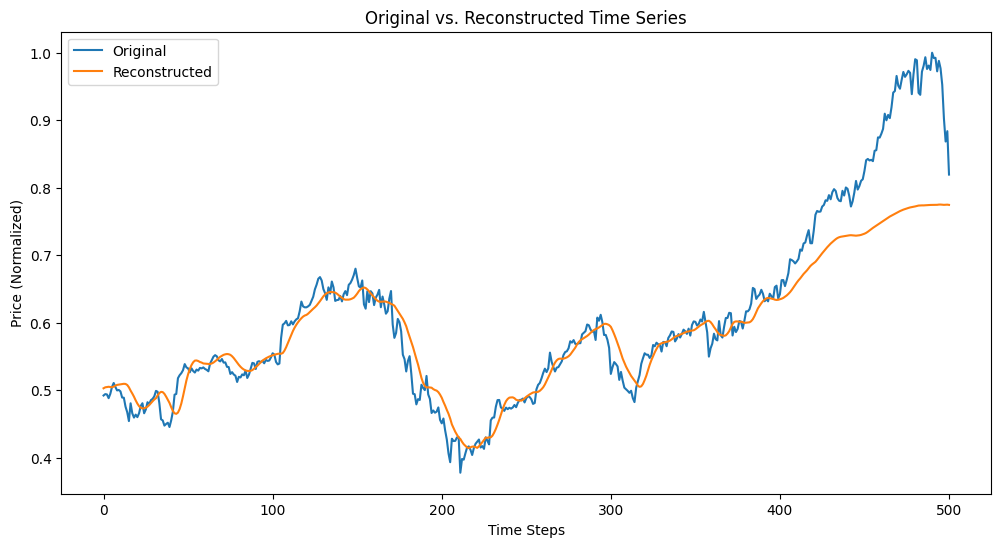

In [18]:
predictions = autoencoder.predict(test_X)
# Plot original vs reconstructed sequences
plt.figure(figsize=(12, 6))
plt.plot(test_Y, label='Original')
plt.plot(predictions[:, -1, 0], label='Reconstructed')
plt.legend()
plt.title('Original vs. Reconstructed Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Price (Normalized)')
plt.show()

### 2. Evaluate the autoencoder's performance:

 Calculate the reconstruction loss using MSE.

In [19]:
# Calculate the reconstruction loss using MSE.
reconstruction_loss = autoencoder.evaluate(test_X, test_X, verbose=0)
print("Reconstruction Loss (MSE):", reconstruction_loss)

Reconstruction Loss (MSE): 0.006462529767304659


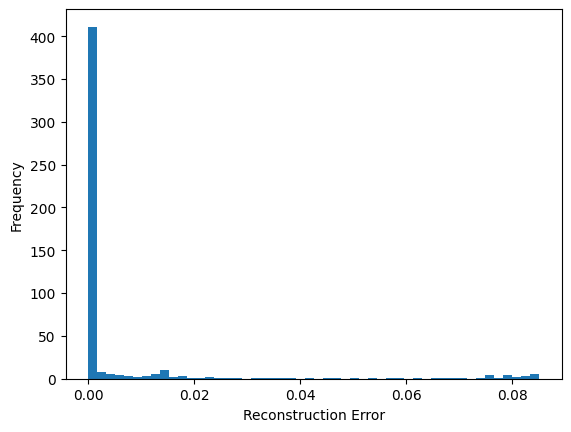

<Figure size 2000x400 with 0 Axes>

In [20]:
mse = np.mean(np.power(test_X - predictions, 2), axis=1)
plt.hist(mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Set a threshold for anomaly detection
threshold = np.max(mse)
# Find the indices of the anomalous data points
anomalies = np.where(mse > threshold)[0]
# Plot the anomalous data points
n = min(len(anomalies), 10)
plt.figure(figsize=(20, 4))
for i in range(n):
   ax = plt.subplot(2, n, i + 1)
   plt.imshow(x_test[anomalies[i]].reshape(28, 28))
   plt.gray()
   ax.get_xaxis().set_visible(False)
   ax.get_yaxis().set_visible(False)
   ax = plt.subplot(2, n, i + 1 + n)
   plt.gray()
   ax.get_xaxis().set_visible(False)
   ax.get_yaxis().set_visible(False)
   plt.imshow(decoded_imgs[anomalies[i]].reshape(28, 28))
plt.show()

Use the encoder’s latent representations for downstream tasks, like sequence classification.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


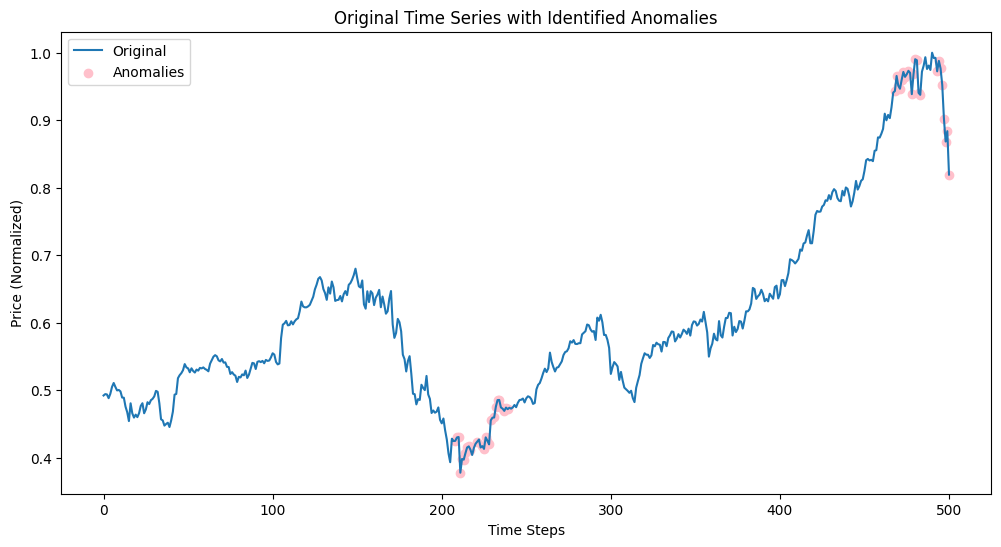

In [22]:
# Use the encoder’s latent representations for downstream tasks, like anomaly identification
latent_representations = encoder.predict(test_X)

# Train an Isolation Forest on the latent representations
model = IsolationForest(contamination=0.1)
model.fit(latent_representations)

anomaly_scores = model.decision_function(latent_representations)

# Identify anomalies (based on a threshold)
anomalies = anomaly_scores < 0

# Analyze the anomalies
plt.figure(figsize=(12, 6))
plt.plot(test_Y, label='Original')
plt.scatter(np.arange(len(test_Y))[anomalies], test_Y[anomalies], color='pink', label='Anomalies')
plt.legend()
plt.title('Original Time Series with Identified Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price (Normalized)')
plt.show()

Key Questions:
 1. How well does the LSTM autoencoder reconstruct the sequences? An MSE of 0.00685 in the
 LSTM autoencoder implies that the model is effectively capturing the temporal patterns in the
 sequence data, leading to accurate reconstructions with minimal error. This low
 reconstruction loss suggests that the LSTM autoencoder is able to preserve the essential
 features of the sequences while filtering out noise.
 2. How does the choice of latent space dimensionality affect reconstruction quality and
 compression?
 The dimensionality of the latent space directly impacts both the model's ability to reconstruct
 the input sequences and the degree of data compression:
 Reconstruction Quality: A higher-dimensional latent space usually allows the model to
 retain more detailed information from the input sequences, often leading to better
 reconstructions. When the dimensionality is too low, there's a risk of losing critical
 information, causing higher reconstruction errors and possibly missing key patterns or
 variations in the sequence data.
 Compression: Reducing latent space dimensionality increases compression by forcing
 the model to retain only the most essential features, effectively filtering out less
 important details. However, over-compression (too low-dimensional) may limit the
 model's ability to represent the full complexity of the data. Conversely, a larger latent
 space improves reconstruction quality but reduces the compression efficiency

# Part 3: Comparison and Discussion

Compare the performance of CNN and LSTM autoencoders:

** 1. Discuss their efficiency in feature extraction for spatial vs. sequential data.**

* CNN autoencoders are highly efficient for feature extraction in spatial data, as their convolutional
 layers excel at capturing spatial hierarchies and localized patterns within images. By focusing on
 local features through filters, CNNs can represent spatial structures and textures, making them
 suitable for tasks like image compression, object recognition, and anomaly detection in visual data.

* LSTM autoencoders are specialized for sequential data due to their ability to capture temporal
 dependencies and relationships over time. LSTMs inherently process data sequentially, allowing
 them to retain information from previous time steps and thus model long-term dependencies
 effectively. They are particularly efficient for extracting features in data where temporal patterns
 matter, such as time-series data, natural language, and audio signal

**2. Analyze the quality of dimensionality reduction for both models.**
* The CNN autoencoder's dimensionality reduction tends to capture high-level spatial features while
 discarding less essential details. Its ability to produce clear clusters in latent space indicates
 effective compression for spatial data
* The dimensionality reduction in an LSTM autoencoder captures the temporal dependencies across
 the sequence, but it often requires a larger latent space to retain sufficient information for high
quality reconstructions.
* The LSTM's latent space may be less clustered than that of a CNN, as
 sequential data often exhibits more complex and overlapping patterns

**3. Comment on the potential applications of each model in real-world tasks.**

 * CNN Autoencode

 Image Compression and Reconstruction: Compressing and reconstructing images by
 reducing spatial data to its core features.
 Anomaly Detection: Detecting irregularities in spatial data (e.g., identifying unusual patterns in
 medical images).
 Data Augmentation and Transfer Learning: Using the latent space features for transfer
 learning, where extracted features can be useful for other computer vision tasks.
 * LSTM Autoencoder:

 Anomaly Detection in Time-Series Data: Detecting deviations in data like network traffic, stock
 prices, or sensor readings.
 Predictive Maintenance: Identifying patterns in equipment performance data that indicate the
 likelihood of failure.
 Natural Language Processing: Capturing temporal patterns in sequential data for tasks like
 language modeling or sequence prediction